В работе ты увидишь комментарии, помеченные разным цветом.

<div class="alert alert-success">
Зеленым цветом помечены оброзцовые решения. Которые можно использовать в дальнейшем.
</div>

<div class="alert alert-warning">
Желтым цветом отмечено то, что ты можешь улучшить или доработать. Можешь учесть это при выполнении следующих работ или доработать проект сейчас, но это не обязательно.
</div>

<div class="alert alert-danger">
Красным цветом помечены моменты, которые необходимо доработать, чтобы проект был принят. Уверен, что у тебя все получится. Буду ждать твою работу на повторное ревью. 
</div>

Будет комфортнее работать над проектом вместе, если ты будешь **писать об изменениях** в проекте по моим рекомендациям. Для этого выбери для своих комментариев 

<div class="alert alert-block alert-info">заметный цвет</div>

Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее.
___

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV

загрузили библиотеки

In [2]:
data = pd.read_csv("/datasets/autos.csv")

Загрузили данные. Посмотрим на на них первично.

In [3]:
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Наша таблица состоит из 354368 строк и сразу видно, что в некоторых признаках существуют пропуски. Нужно сделать предобработку на пропуски, проверить на дубли, а также поискать странности в данных.

Также опишем признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
Целевой признак
- Price — цена (евро)

Сразу отбросим признаки, которые отвечают за характеристику пользователя/анкеты на сайте (расчитываемая цена не должна изменяться, например, из-за давности захода пользователя на сайт). 

Список этих признаков:
- DateCreated
- LastSeen

Уберём их, а также месяц регистрации (год регистрации автомобиля безусловно важен, но месяц не так определяет стоимость автомобиля.

<div class="alert alert-danger">
    
**Комментарий ревьюера**
    
Нет, сразу отбрасывать нельзя)Т.к. мы рискуем потерять информацию) 
    
1) Дата скачивания анкеты из базы может помочь найти выбросы
    
2) Почтовые коды могут означать области, а в разных областях могут быть разные закономерности на цены
</div>

<div class="alert alert-block alert-info">Спасибо! Ок, понял, оставляю дату скачивания и почтовый код, через ячейку рассматриваю их.</div>


<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Супер)Всегда сначала изучаем, а потом думаем что удалять)
</div>

In [4]:
df = data.drop(["DateCreated", "LastSeen", 'RegistrationMonth'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
DateCrawled         354369 non-null object
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
NumberOfPictures    354369 non-null int64
PostalCode          354369 non-null int64
dtypes: int64(6), object(7)
memory usage: 35.1+ MB


count                  354369
unique                     34
top       2016-04-04 00:00:00
freq                    13591
first     2016-03-06 00:00:00
last      2016-04-08 00:00:00
Name: DateCrawled, dtype: object


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


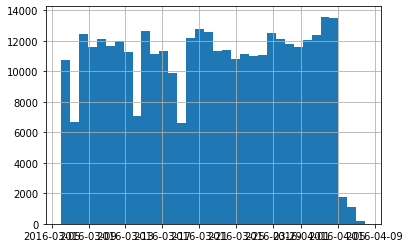

In [5]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled']).dt.round('D')

print(df['DateCrawled'].describe())
df['DateCrawled'].hist(bins = 34)

In [6]:
df[df['DateCrawled'] > '2016-04-05' ].isna().mean()

DateCrawled         0.000000
Price               0.000000
VehicleType         0.095741
RegistrationYear    0.000000
Gearbox             0.064048
Power               0.000000
Model               0.052493
Kilometer           0.000000
FuelType            0.088478
Brand               0.000000
NotRepaired         0.194454
NumberOfPictures    0.000000
PostalCode          0.000000
dtype: float64

<div class="alert alert-block alert-info">Дата скачивалась 34 дня (уникальных значений) и довольно стабильно. Мало даты за последние дни - посмотрел на них, там нет бо'льшего кол-ва пропусков, чем в другие дни. Насколько понял, столбец не может быть полезным, поэтому все же выкидываю его.</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Если ты увидел, что дата скачивания 2016 год и авто выше этого года быть не может, тогда ок)
</div>

In [7]:
df = df.drop(['DateCrawled'], axis=1)

count    354369.000000
mean      50508.689087
std       25783.096248
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64


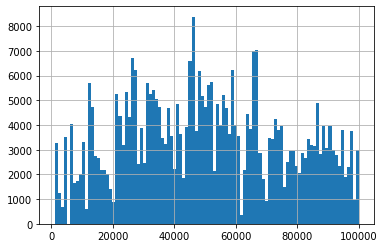

In [8]:
print(df['PostalCode'].describe())
df['PostalCode'].hist(bins = 100)

<div class="alert alert-block alert-info">В Почтовых кодах пропусков нет, данные в порядке, просто используем дальше в расчётах (исправил далее, чтобы он тоже учитывался)</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Супер)Еще бы посмотреть на то, насколько этот признак в итоге окажется полезным)
</div>

Убрали столбцы, теперь разберёмся с пропусками

In [9]:
df.isna().mean()

Price               0.000000
VehicleType         0.105794
RegistrationYear    0.000000
Gearbox             0.055967
Power               0.000000
Model               0.055606
Kilometer           0.000000
FuelType            0.092827
Brand               0.000000
NotRepaired         0.200791
NumberOfPictures    0.000000
PostalCode          0.000000
dtype: float64

В таблице много пропусков в NotRepaired, VehicleType, FuelType, а также есть пропуски в Gearbox и Model. Разберемся с ними по порядку.

Пропущенные значения в NotRepaired (не было ремонта) скорее всего означают, что ремонта не было и поэтому пользователь не указал это. Заполним пропуски положительным значением

In [10]:
# df['NotRepaired'].unique()
df["NotRepaired"].fillna("yes", inplace=True)
df["NotRepaired"].isna().mean()

0.0

<div class="alert alert-warning">
    
**Комментарий ревьюера**
    
Еще какие-то варианты рассматривались?)Как меняется результат?)
</div>

<div class="alert alert-block alert-info">Тут не понял, что значит. Заполнить его наоборот значение "нет"? Или откинуть? Результат имеется ввиду качество модели или что?</div>


<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Да)Что будет если заполнить нет или заполнить "unknown" и как будет меняться результат модели)
</div>

Теперь перейдём к столбцу VehicleType (тип автомобиля) и Model (модель). Учитывая, что в таблице есть модель автомобиля - возьмём данные по типу автомобиля оттуда. Для этого создадим словарь модель - тип автомобиля, а также функцию которая пройдётся по строкам и соответствующе заполнит (пустые значения в модели и в типе автомобиля заполним unknown, чтобы учитывать и случай когда низвестны данные). Учитывая, что признаки FuelType (тип топлива) и Gearbox (тип коробки) схожи по смыслу с типом автомобиля, по ним пройдёмся также.

In [11]:
print(df["VehicleType"].isna().mean())
print(df["Model"].isna().mean())
print(df["FuelType"].isna().mean())
print(df["Gearbox"].isna().mean())

0.1057936783409384
0.055605879746817584
0.09282696849893755
0.055967085156997366


In [12]:
dict_model_veh = df.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()
# словарь для типа атвтомобиля
dict_model_fuel = df.groupby("Model")['FuelType'].agg(lambda x:x.value_counts().index[0]).to_dict()
# словарь для типа топлива
dict_model_gear = df.groupby("Model")['Gearbox'].agg(lambda x:x.value_counts().index[0]).to_dict()
# словарь для типа топлива

создали словари для обоих случаев, перейдём к функциям и заполнению

In [13]:
df["Model"] = df["Model"].fillna("unknown")
df["VehicleType"] = df["VehicleType"].fillna("unknown")

def model_to_veh(row):
    model = row["Model"]
    veh = row["VehicleType"]
    
    if model == "unknown" and veh == "unknown":
        return "unknown"
    elif model == "unknown" and veh != "unknown":
        return veh
    
    return dict_model_veh[model]

df["VehicleType"] = df[["VehicleType", "Model"]].apply(model_to_veh, axis=1)

print(df["VehicleType"].isna().mean())
print(df["Model"].isna().mean())

0.0
0.0


<div class="alert alert-success">
    
**Комментарий ревьюера**
    
Какими еще вариантами можно было заполнить? Разве не может быть так, что у авто
</div>

<div class="alert alert-block alert-info">Тут совсем не понял - видимо что-то не заполнено. Мне кажется модель - самое подробное деление по этому по ней заполнять наиболее логично, можно еще по бренду (но бренд не производит один тип)</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Видимо часть моего комментария стерлась) Ну смотри, у нас ведь может быть так, что 1 модель в зависимости от комплектации будет иметь движок например слабее и тогда и вид топлива другой или коробку. Не знаю так ли это)Но суть вопроса была в том, чтобы ты изучил это)
</div>

Тип двигателя заполнили, перейдём к топливу

In [14]:
df["FuelType"] = df["FuelType"].fillna("unknown")

def model_to_fuel(row):
    model = row["Model"]
    fuel = row["FuelType"]
    
    if model == "unknown" and fuel == "unknown":
        return "unknown"
    elif model == "unknown" and fuel != "unknown":
        return fuel
    
    return dict_model_fuel[model]

df["FuelType"] = df[["FuelType", "Model"]].apply(model_to_fuel, axis=1)

print(df["FuelType"].isna().mean())

0.0


Топливо сделали, заполним и коробку

In [15]:
df["Gearbox"] = df["Gearbox"].fillna("unknown")

def model_to_gear(row):
    model = row["Model"]
    gear = row["Gearbox"]
    
    if model == "unknown" and gear == "unknown":
        return "unknown"
    elif model == "unknown" and gear != "unknown":
        return gear
    
    return dict_model_gear[model]

df["Gearbox"] = df[["Gearbox", "Model"]].apply(model_to_gear, axis=1)

print(df["Gearbox"].isna().mean())

0.0


<div class="alert alert-danger">
    
**Комментарий ревьюера**
    
Это ведь копипаст)Пожалуйста исправь)
</div>

<div class="alert alert-block alert-info">Тут тоже не понял - пометка красная, значит надо точно её поправить, но я не понимаю на что исправить. Убрать это всё в одну функцию? Или использовать разные логики? Или просто откинуть пустые значения? </div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
model_to_gear и model_to_fuel у тебя почти 1 в 1, это плохо)Можно написать другую функцию, которая сможет делать всё одна)
</div>

Уберём и дупликаты

In [16]:
df = df.drop_duplicates()

Еще раз посмотрим на данные по типу данных

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327385 entries, 0 to 354368
Data columns (total 12 columns):
Price               327385 non-null int64
VehicleType         327385 non-null object
RegistrationYear    327385 non-null int64
Gearbox             327385 non-null object
Power               327385 non-null int64
Model               327385 non-null object
Kilometer           327385 non-null int64
FuelType            327385 non-null object
Brand               327385 non-null object
NotRepaired         327385 non-null object
NumberOfPictures    327385 non-null int64
PostalCode          327385 non-null int64
dtypes: int64(6), object(6)
memory usage: 32.5+ MB


Разобъём столбцы на категориальные и численные

In [18]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
num_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures', 'PostalCode']

Теперь численные признаки проверим на выбросы.

In [19]:
df[num_columns].describe()

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures,PostalCode
count,327385.000000,327385.000000,327385.000000,327385.000000,327385.0,327385.000000
mean,4385.449614,2004.182773,109.886091,128248.667471,0.0,50733.997336
std,4510.908428,89.914389,195.767964,37955.820872,0.0,25821.351863
min,0.000000,1000.000000,0.000000,5000.000000,0.0,1067.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,0.0,30419.000000
50%,2699.000000,2003.000000,103.000000,150000.000000,0.0,49504.000000
75%,6300.000000,2008.000000,141.000000,150000.000000,0.0,71404.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0,99998.000000


Кратко по численным признакам:
- Price нужно оценить данные, точно убрать нули (мы предсказываем цену, нулевая цена - это какая-о ошибка)
- RegistrationYear - нужно оценить и явно убрать выбросы (1000 год  9999 явно смущают)
- Power нужно оценить данные, точно убрать нули и посмотреть большие выбросы (максимум 20 000 гораздо больше 75% значения в 143)
- Kilometer на первый взгляд данные нормальны
- NumberOfPictures состоит из нулей - можно выкинуть его из данных без потерь
- PostalCode - всё ок

Приступим по очереди

count    327385.000000
mean       4385.449614
std        4510.908428
min           0.000000
25%        1000.000000
50%        2699.000000
75%        6300.000000
max       20000.000000
Name: Price, dtype: float64


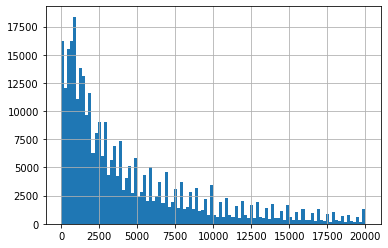

In [20]:
print(df['Price'].describe())
df['Price'].hist(bins = 100)

Убираем только нули, остальные данные действительно распределенно идут до максимум

In [21]:
df = df[df['Price'] > 0]
# df['Price'].describe()

С ценой разобрались, теперь к году регистрации

count    317590.000000
mean       2004.087934
std          80.661666
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


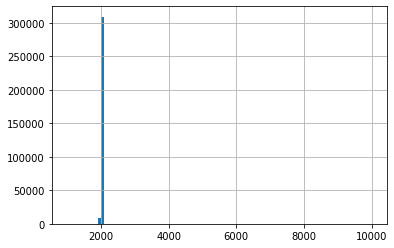

In [22]:
print(df['RegistrationYear'].describe())
df['RegistrationYear'].hist(bins = 100)

Выбросы слишком сильные (даже не видны на графике), возъмём минимум за 1900 год, а максимумом максимальный год загрузки анкеты (исходим из логики, что это настоящее время)

<div class="alert alert-success">
    
**Комментарий ревьюера**
    
А данные были другие)
</div>

<div class="alert alert-block alert-info">Тут тоже не понял - данные другие - это имеется ввиду, что надо по другому отбрасывать? Или не отбрасывать и учиывать и эти года для точности?</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Это я про то, что максимум выгрузки это 2016 год, а у тебя если не ошибаюсь было 2021)
</div>

count    304511.000000
mean       2002.538362
std           6.992269
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


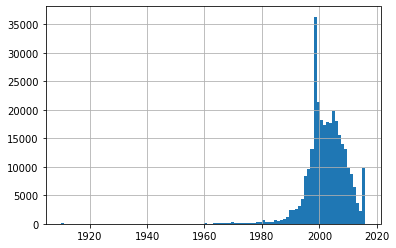

In [23]:
max_year = pd.to_datetime(data['DateCreated']).max().year
# display(max_year)
df = df[(df['RegistrationYear'] <= max_year) & (df['RegistrationYear'] > 1900)]
df['RegistrationYear'].hist(bins = 100)
print(df['RegistrationYear'].describe())

C годами предобработку закончили, взглянем на мощность.

count    304511.000000
mean        111.700684
std         190.544270
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


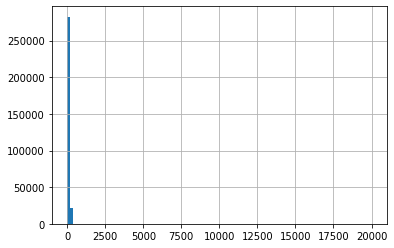

In [24]:
print(df['Power'].describe())
df['Power'].hist(bins = 100)

Ситуация аналогичная годам, график не может показать ввиду слишком большого выброса. Ограничим: сразу возьмём больше нуля, а также меньше 1000

count    273249.000000
mean        120.555310
std          54.888698
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1000.000000
Name: Power, dtype: float64


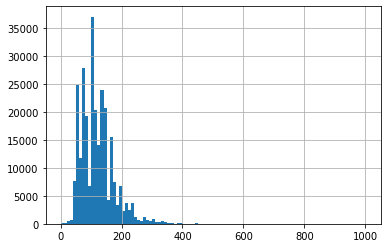

In [25]:
df = df[(df['Power'] <= 1000) & (df['Power'] > 0)]
df['Power'].hist(bins = 100)
print(df['Power'].describe())

Видно, что можно снизить значения еще до примерно 600 и не поерять значимых данных. Сократим, а также сразу уберём признак количество картинок как пустой.

In [26]:
df = df[df['Power'] <= 600]
df = df.drop(['NumberOfPictures'], axis = 1)
# df.info()

Подготовка данных завершена, перейдём к следующему шагу: Обучение моделей

## Обучение моделей

Для сравнения моделей мы будем использовать следюущие:
- CatBoost
- LightGBM
- Linear

Для начала подготовим данные.

In [27]:
features = df.drop(['Price'], axis = 1)
target = df['Price']

encoder = OrdinalEncoder()
features[cat_columns] = encoder.fit_transform(features[cat_columns])

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

scaler = StandardScaler()
num_columns = ['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']
scaler.fit(features_train[num_columns])
features_train[num_columns] = scaler.transform(features_train[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

<div class="alert alert-danger">
    
**Комментарий ревьюера**
    
Мы должны обучать скалер только на трейн части. Поэтому сначала делим нашу выборку, а уже потом обучаем на трейне и трансформим
</div>

<div class="alert alert-block alert-info">Спасибо, не знал и делал всегда так! Поменял местами</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Хорошо, что узнал сейчас)Я многие шишки набил, когда получал отказы на собеседованиях)
</div>

Подготовку закончили, перейдём к обучению моделей

### CatBoost

Возьмём 2 модели с разной глубиной (10 и 5)

In [ ]:
%%time
catboost = CatBoostRegressor()
parametrs_cat = {'loss_function' : ['RMSE'],
             'iterations' : [400],
              'depth' : [10, 5],
              'learning_rate' : [0.8],
              'verbose' : [100],
              'random_state' : [12345]}
clf_cat = GridSearchCV(catboost, parametrs_cat)

clf_cat.fit(features_train, target_train)

print(clf_cat.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0:	learn: 2578.4063703	total: 271ms	remaining: 1m 48s
100:	learn: 1453.0381759	total: 21.5s	remaining: 1m 3s
200:	learn: 1314.8304136	total: 42.2s	remaining: 41.8s
300:	learn: 1225.3726927	total: 1m 3s	remaining: 20.8s
399:	learn: 1151.1273530	total: 1m 24s	remaining: 0us
0:	learn: 2553.5629445	total: 116ms	remaining: 46.3s


<div class="alert alert-danger">
    
**Комментарий ревьюера**
    
Откуда взяли гиперпараметры?)Нужно их подобрать не используя тестовую часть)для этого или выдели еще валидационную часть или воспользуйся cv)Если будут какие-то вопросы или нужна помощь, я всегда рад)Жду доработок!)
</div>

<div class="alert alert-block alert-info">Взял параметры просто так, чтобы посмотреть на разных гиперпараметрах как будет работать и дальше сделать вывод.В задаче было указано попробовать разные параметры, 2-3 из-за того, что обучается долго. Добавил GridSearchCV в каждый, затем по лучшему параметру вынес обучение (чтобы замерить время для сравнения) это то, что нужно?</div>

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
Супер)
</div>

In [ ]:
%%time
best_cat = CatBoostRegressor(loss_function = 'RMSE',
             iterations = 400,
              depth = 5,
              learning_rate = 0.8,
              verbose = 100,
              random_state = 12345)
best_cat.fit(features_train, target_train)

In [ ]:
%%time
best_cat_pred = best_cat.predict(features_test)

In [ ]:
print("RMSE catboost", mean_squared_error(target_test, best_cat_pred)**(0.5))

### LightGBM

Возьмём также разную глубину (15, 10, 5) для сравнения.

In [ ]:
%%time
LGBM = LGBMRegressor()
parametrs_LGBM = {'metric' : ['RMSE'],
                  'n_estimators' : [100],
              'depth' : [15, 10, 5],
              'learning_rate' : [0.8],
              'verbose' : [50],
              'random_state' : [12345]}
clf_LGBM = GridSearchCV(LGBM, parametrs_LGBM)

clf_LGBM.fit(features_train, target_train)

print(clf_LGBM.best_params_)

In [ ]:
%%time
best_LGBM = LGBMRegressor(metric = 'RMSE',
                  n_estimators = 100,
              depth = 15,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
best_LGBM.fit(features_train, target_train)

In [ ]:
%%time
best_LGBM_pred = best_LGBM.predict(features_test)

In [ ]:
print("RMSE LGBM", mean_squared_error(target_test, best_LGBM_pred)**(0.5))

### Linear

Для сравнения третьей возьмём просту модель Линейной регрессии

In [ ]:
%%time

LINR = LinearRegression(normalize=True)

LINR.fit(features_train, target_train)

In [ ]:
%%time
LINR_pred = LINR.predict(features_test)

In [ ]:
print("RMSE LINEAR", mean_squared_error(target_test, LINR_pred)**(0.5))

Имея данные по всем моделям, сравним итоговые результаты

## Анализ моделей

In [ ]:
data = [['56.6 s', '67.7 ms', 1694.44],
        ['5.29 s', '464 sms', 1745.85],
        ['83.6 ms', '7.77 ms', 2998.93]]

model = ['CatBoost', 'LightGBM', 'Linear']

metrika = ['CPU times fit', 'CPU times predict', 'RMSE']

result = pd.DataFrame(data = data, index = model, columns = metrika)

display(result)

- Наибольшую скорость обучения и предсказания показала простая модель Линейной Регрессии (операции выполнялись за милисекунды, где остальным моделям требовались секунды), однако она же показала и худший RMSE тоже с большим отрывом (почти в 2 раза). 
- Вторая по скорости обучения - это модель LGBM, которая показала хороший RMSE, но заняла третье (худшее) место по скорости предсказаний. 
- Модель же Catboost показала самое большое время обучения, но при этом лучший RMSE и очень достойное время предикта!

Главный вывод: **Для наилушего предсказания мы выбираем модель Catboost за лучший RMSE, а также за приемлемые значения скорости предсказания.** Время обучения не так важно, поскольку важнее результат и как быстро мы сможем его предоставлять!

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

<div class="alert alert-success">
    
**Комментарий ревьюера v_2**
     
У меня вопросов больше нет, ты большой молодец)Если что, пиши через куратора)Успехов в следующих проектах!)

время

https://www.youtube.com/watch?v=u433nrxdf5k&ab_channel=DataMininginAction

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
</div>